In [27]:
from __future__ import print_function
from __future__ import absolute_import

from generate_data import *
from misc_utils import make_sure_path_exists, make_buckets
from sklearn.model_selection import train_test_split
from theano_time_corex import *

import argparse
import baselines
import json

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# define arguments

In [28]:
class T:
    pass

args = T()

args.nt = 10
args.train_cnt = 16
args.snr = 5.0
args.min_cor = 0.8
args.max_cor = 1.0
args.min_var = 1.0
args.max_var = 1.0

# define the methods

In [29]:
methods = [
    (baselines.TimeVaryingGraphLasso(name='T-GLASSO'), {
        'lamb': 0.3,
        'beta': 0.3,
        'indexOfPenalty': 1,
        'max_iter': 100}),

#     (baselines.TCorex(tcorex=TCorex, name='T-Corex (Sigma)'), {
#         'max_iter': 500,
#         'anneal': True,
#         'l1': 0.1,
#         'reg_type': 'Sigma'
#     }),

#     (baselines.TCorex(tcorex=TCorex, name='T-Corex (W)'), {
#         'max_iter': 500,
#         'anneal': True,
#         'l1': 0.1,
#         'reg_type': 'W'
#     }),

#     (baselines.TCorex(tcorex=TCorexPrior1, name='T-Corex + priors (W, method 1)'), {
#         'max_iter': 500,
#         'anneal': True,
#         'l1': 0.1,
#         'lamb': 0.9,
#         'reg_type': 'W',
#         'init': True
#     }),

    (baselines.TCorex(tcorex=TCorexPrior2, name='T-Corex + priors (W, method 2)'), {
        'max_iter': 500,
        'anneal': True,
        'l1': 0.1,
        'lamb': 0.9,
        'reg_type': 'W',
        'init': True
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples)'), {
        'max_iter': 500,
        'anneal': True,
        'l1': 0.1,
        'gamma':2.0,
        'reg_type': 'W',
        'init': True
    }),
]

# Don't calculate the inference time of both T-CorEx and T-GLASSO

In [30]:
glasso_times = np.loadtxt('resources/runtimes.npy')[:, 0]
glasso_nvs = [2**i for i in range(3, 11)]

### run T-CorEx

In [31]:
tcorex_nvs = [2**i for i in range(3, 14)]
tcorex_bss = [x // 8 for x in tcorex_nvs]
tcorex_ms = [8 for x in tcorex_nvs]
tcorex_times = np.zeros((len(tcorex_nvs,)))

In [ ]:
for tid, (m, bs, nv) in enumerate(zip(tcorex_ms, tcorex_bss, tcorex_nvs)):

    (data1, _) = generate_nglf_from_model(nv, m, args.nt // 2, ns=args.train_cnt, snr=args.snr,
                                          min_var=args.min_var, max_var=args.max_var,
                                          min_cor=args.min_cor, max_cor=args.max_cor)
    (data2, _) = generate_nglf_from_model(nv, m, args.nt // 2, ns=args.train_cnt, snr=args.snr,
                                          min_var=args.min_var, max_var=args.max_var,
                                          min_cor=args.min_cor, max_cor=args.max_cor)
    train_data = data1 + data2
    
    (method, params) = methods[1]
    name = method.name
    if 'Corex' in name:
        params['nt'] = len(train_data)
        params['nv'] = nv
        params['n_hidden'] = m
    print("Timing {} (nv = {}) ... ".format(name, nv))
    cur_time = method.timeit(train_data, params)
    tcorex_times[tid] = cur_time
    print("\ttook {:.2f} seconds".format(cur_time))

Fixed SNR: 5.0
Fixed SNR: 5.0
Timing T-Corex + priors (W, method 2) (nv = 8) ... 
Annealing iteration finished, time = 1.37458896637
Annealing iteration finished, time = 1.37254786491
Annealing iteration finished, time = 1.38617491722
Annealing iteration finished, time = 1.37696290016
Annealing iteration finished, time = 1.38241410255
Annealing iteration finished, time = 1.39038705826
Annealing iteration finished, time = 1.37113499641
	took 15.94 seconds
Fixed SNR: 5.0
Fixed SNR: 5.0
Timing T-Corex + priors (W, method 2) (nv = 16) ... 
Annealing iteration finished, time = 1.58244085312
Annealing iteration finished, time = 1.58218502998
Annealing iteration finished, time = 1.5741288662
Annealing iteration finished, time = 1.59154701233
Annealing iteration finished, time = 1.57331895828
Annealing iteration finished, time = 1.59202003479
Annealing iteration finished, time = 1.58396697044
	took 17.46 seconds
Fixed SNR: 5.0
Fixed SNR: 5.0
Timing T-Corex + priors (W, method 2) (nv = 32) ... 

In [7]:
# np.savetxt('resources/tcorex_times.npy', tcorex_times)

In [32]:
tcorex_times = np.loadtxt('resources/tcorex_times.npy')

### plot the scalability plots

<IPython.core.display.Javascript object>


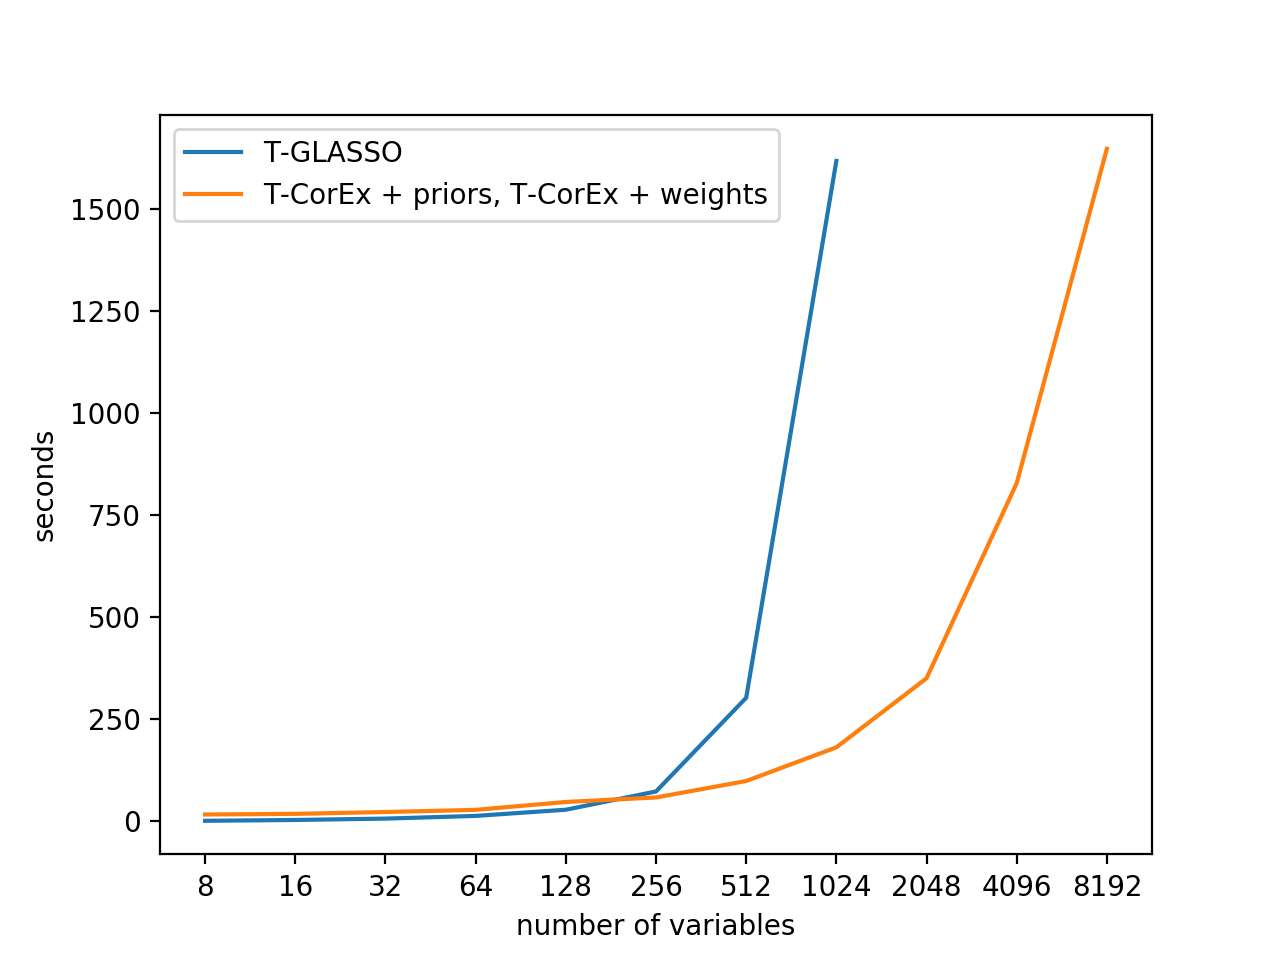

In [33]:
plt.figure()
plt.plot(glasso_times)
plt.plot(tcorex_times)

plt.xticks(range(len(tcorex_nvs)), tcorex_nvs)
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
plt.ylabel('seconds')
plt.xlabel('number of variables')

<IPython.core.display.Javascript object>


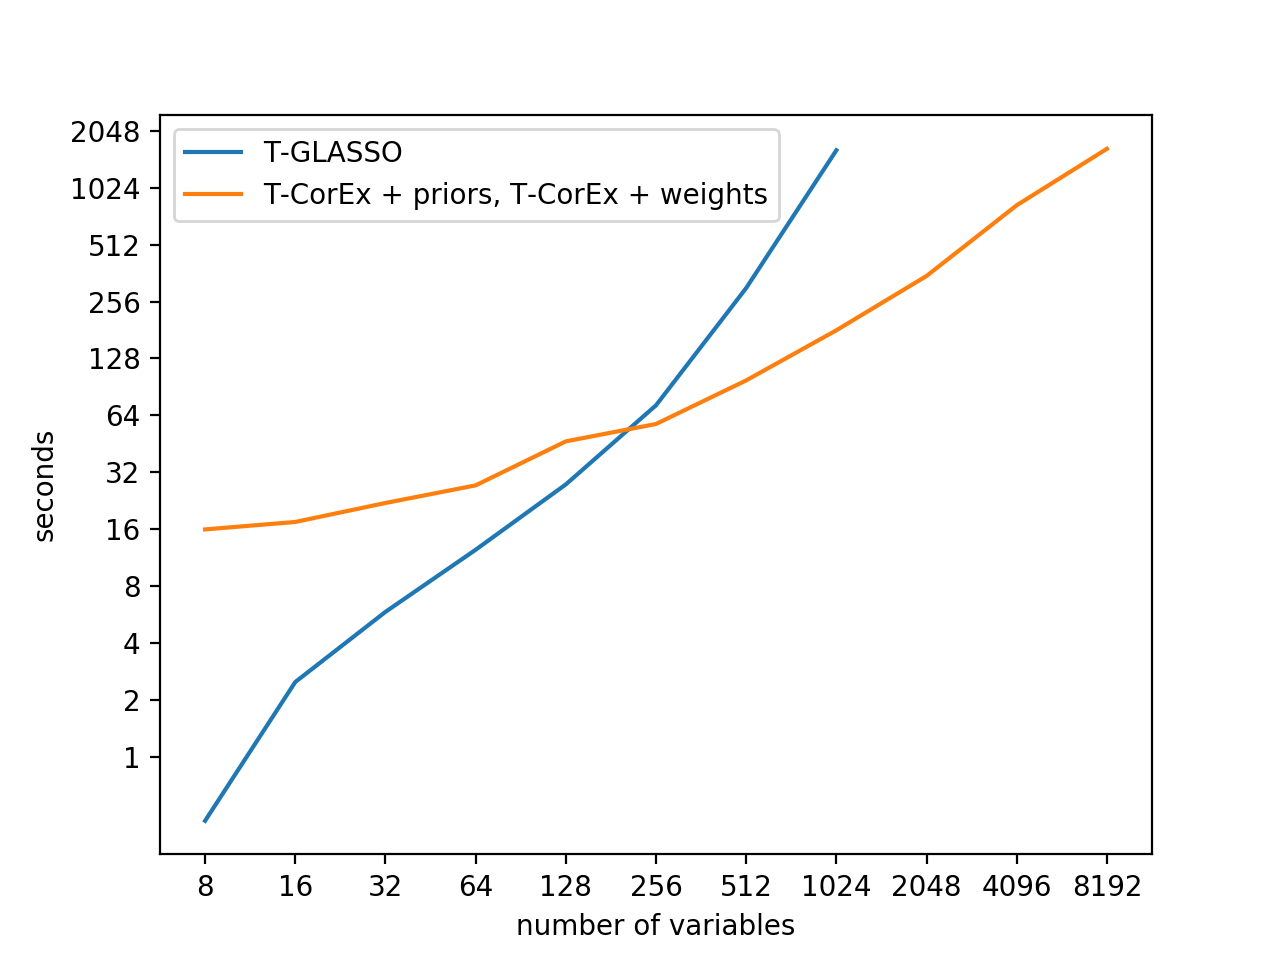

In [34]:
plt.figure()
plt.plot(np.log2(glasso_times))
plt.plot(np.log2(tcorex_times))
plt.xticks(range(len(tcorex_nvs)), tcorex_nvs)
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
plt.ylabel('seconds')
plt.yticks(range(12), [2**i for i in range(12)])
plt.xlabel('number of variables')

<IPython.core.display.Javascript object>


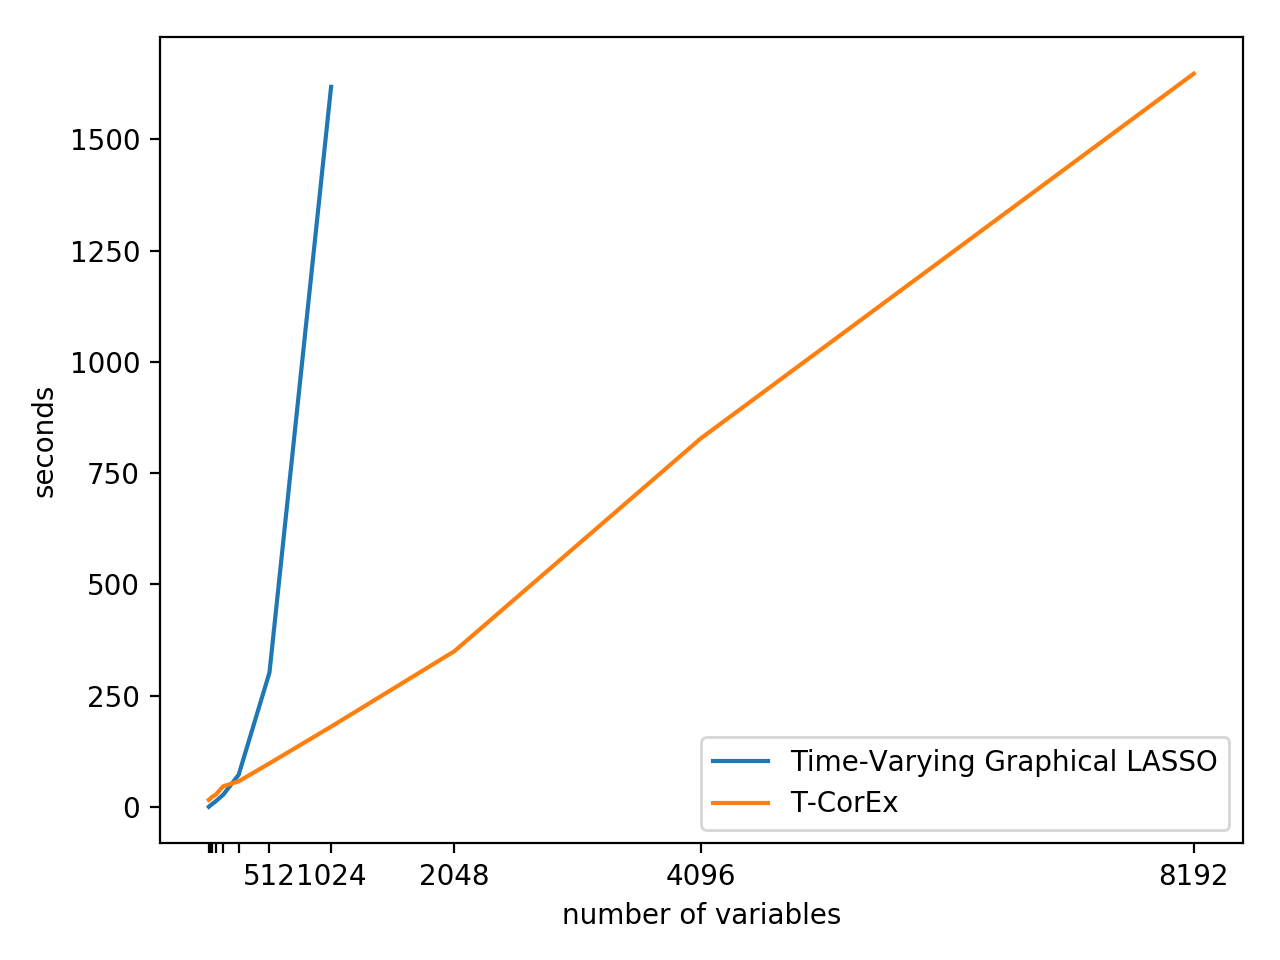

In [40]:
with PdfPages('plots/scalability.pdf') as pdf:
    plt.figure()
    plt.plot(glasso_nvs, glasso_times)
    plt.plot(tcorex_nvs, tcorex_times)
    plt.xticks(tcorex_nvs, ['' if x < 512 else x for x in tcorex_nvs])
    plt.legend(['Time-Varying Graphical LASSO', 'T-CorEx'])
    plt.ylabel('seconds')
    plt.xlabel('number of variables')
    
    plt.tight_layout()
    pdf.savefig()

# Հայերեն

In [38]:
from matplotlib.backends.backend_pdf import PdfPages

<IPython.core.display.Javascript object>


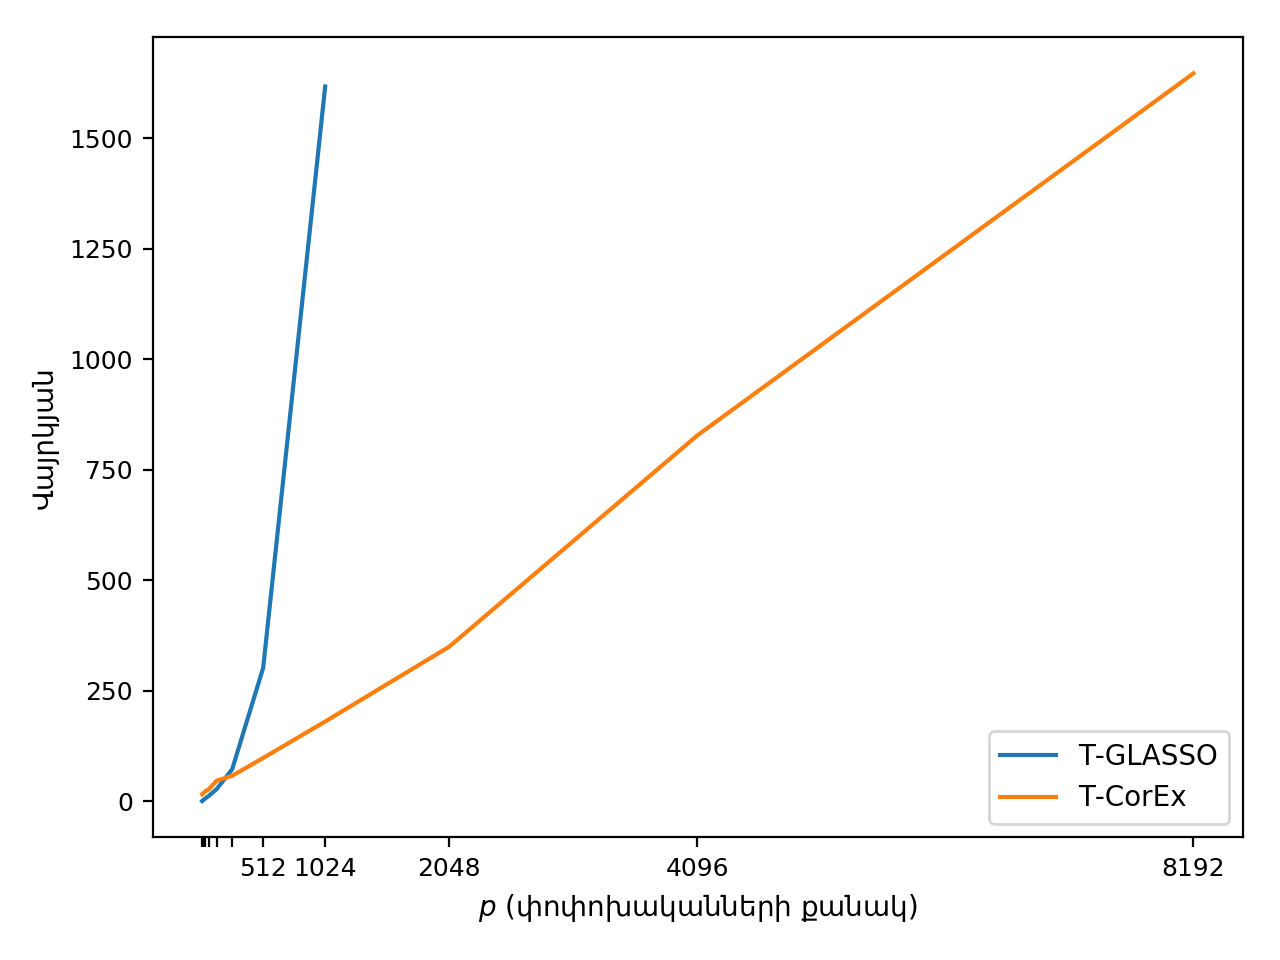

In [9]:
with PdfPages('plots/scalability-arm.pdf') as pdf:
    plt.figure()
    plt.plot(glasso_nvs, glasso_times)
    plt.plot(tcorex_nvs, tcorex_times)
    plt.yticks(fontsize=9)
    plt.xticks(tcorex_nvs, ['' if x < 512 else x for x in tcorex_nvs], fontsize=9)
    plt.legend([u'T-GLASSO', u'T-CorEx'])
    plt.ylabel(u'Վայրկյան')
    plt.xlabel(u'$p$ (փոփոխականների քանակ)')

    plt.tight_layout()
    pdf.savefig()

# load from resources

In [4]:
import json

<IPython.core.display.Javascript object>


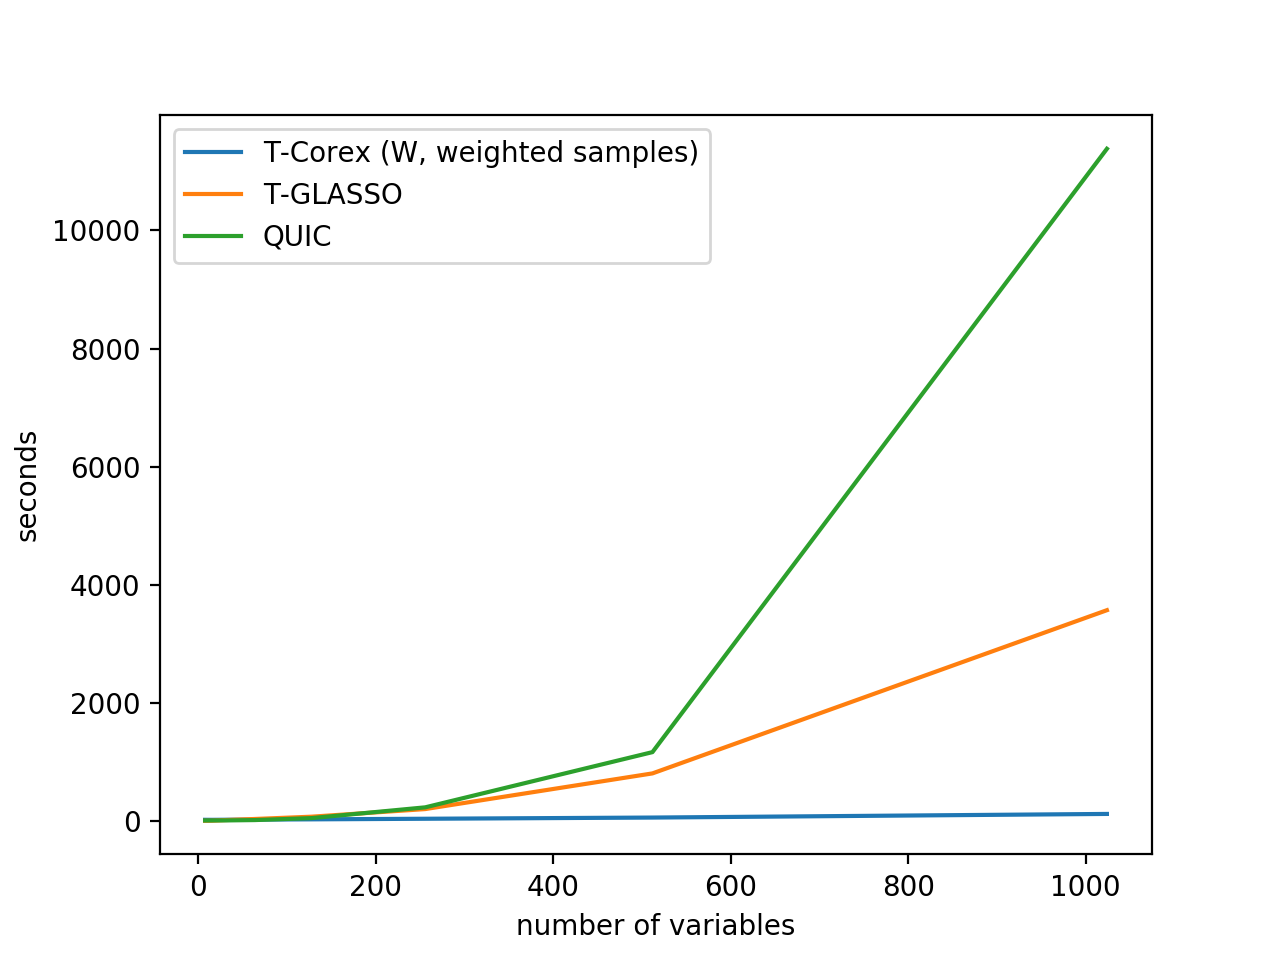

In [5]:
path = 'resources/nt10.m8.train_cnt16.min_var0.25.max_var4.00.json'
with open(path) as f:
    data = json.load(f)
methods = data.keys()

plt.figure()
for m in methods:
    nvs = [x[0] for x in data[m]]
    times = [x[1] for x in data[m]]
    plt.plot(nvs, times)
plt.legend(methods)
plt.ylabel('seconds')
plt.xlabel('number of variables')

# Just T-CorEx

In [2]:
with open('resources/nt10.m8.train_cnt16.min_var0.25.max_var4.00.json', 'r') as fin:
    data = json.load(fin)

<IPython.core.display.Javascript object>


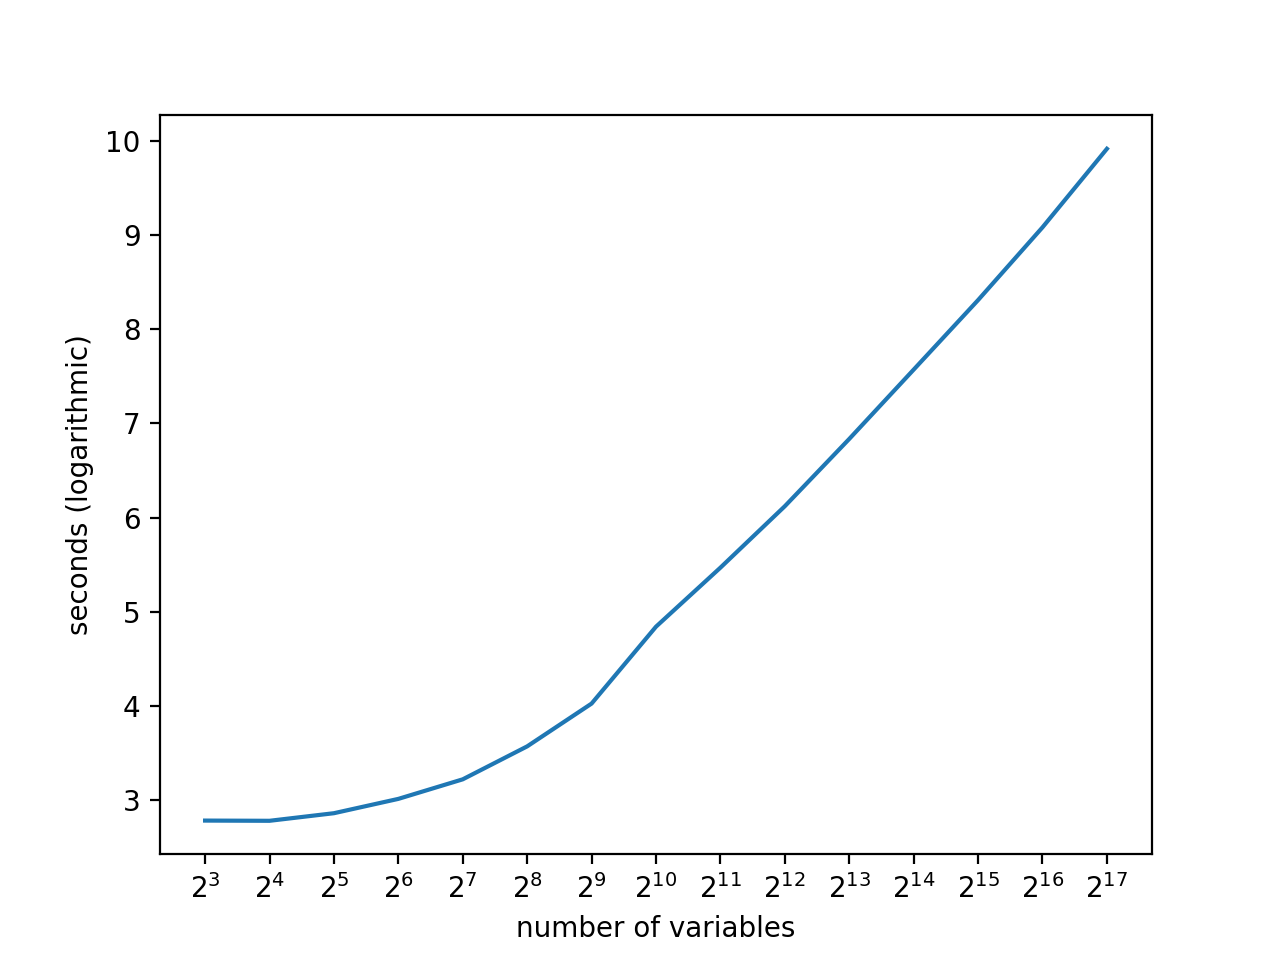

In [20]:
tcorex = data['T-Corex (W, weighted samples)']
plt.figure()
plt.xlabel('number of variables')
plt.ylabel('seconds (logarithmic)')
nvs = [x[0] for x in tcorex]
times = np.array([x[1] for x in tcorex])
plt.plot(np.log(times))
plt.xticks(range(len(nvs)), ['$2^{}{}{}$'.format('{', i, '}') for i in range(3, 18)]);

<IPython.core.display.Javascript object>


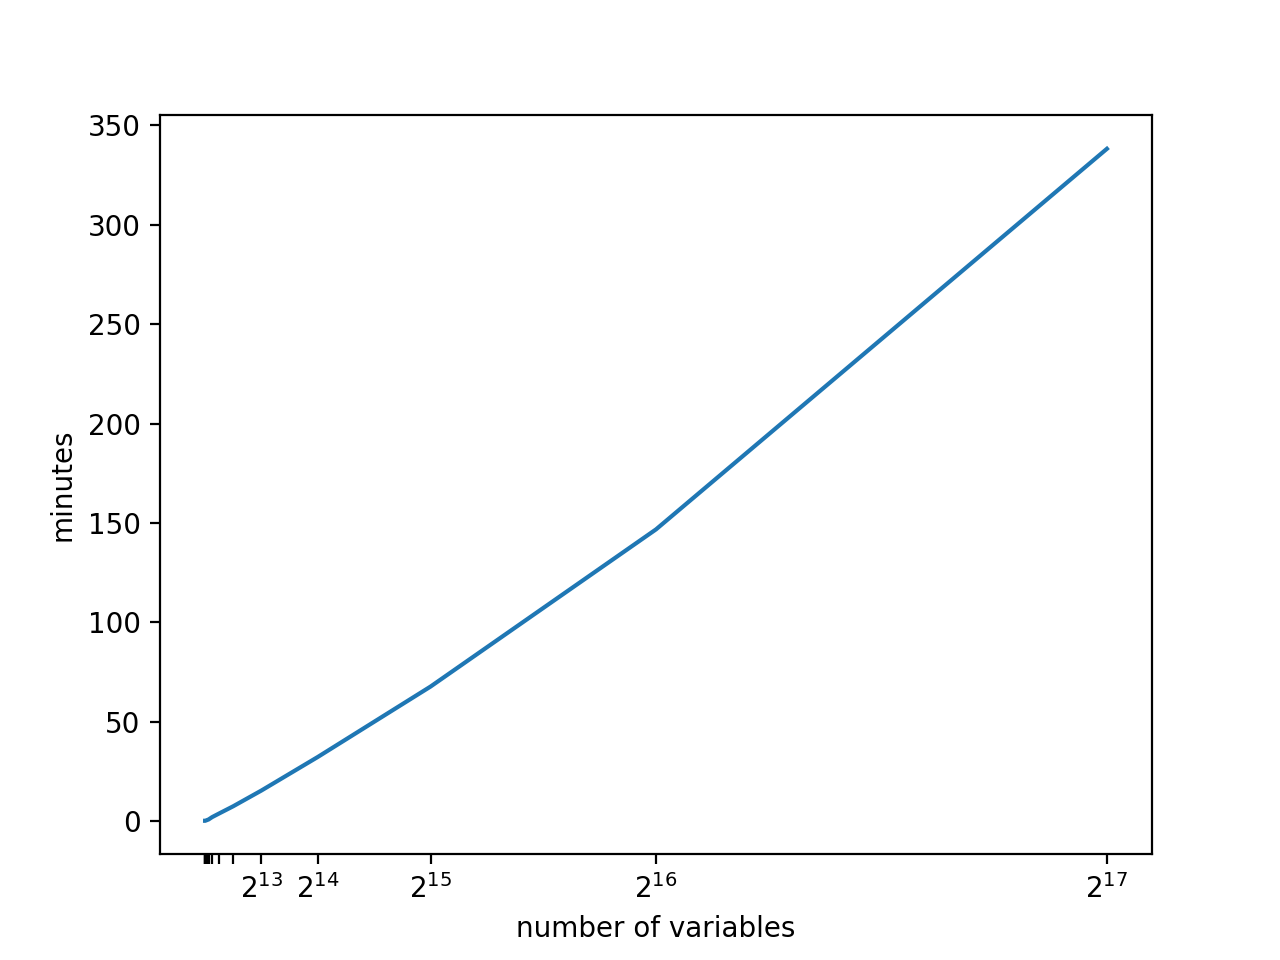

In [26]:
tcorex = data['T-Corex (W, weighted samples)']
plt.figure()
plt.xlabel('number of variables')
plt.ylabel('minutes')
nvs = [x[0] for x in tcorex]
times = np.array([x[1] for x in tcorex]) / 60.0
plt.plot(nvs, times)
x_ticks = ['' for i in range(3, 13)] + ['$2^{}{}{}$'.format('{', i, '}') for i in range(13, 18)]
plt.xticks(nvs, x_ticks);